### COMP 473 Group Project

#### Facial Expression Recognition: 6-Class Classification

##### Importing main libraries used

In [ ]:
!pip install opencv-python
!pip install tensorflow
!pip install imutils
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install Pillow

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random
import PIL
import pandas as pd

classes = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

#### Training Metrics Graph
Automatically update loss and accuracy of training and validation set and display the graph as the model gets trained

In [2]:
from IPython.display import clear_output


class PlotTrain(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        #To plot the graph
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], label='val_' + metric)

        axs[i].legend()
        axs[i].grid()
        plt.tight_layout()
        plt.show()

In [2]:
def myClassType(myClass):
    return_class = []
    for i in myClass:
        if (i == 0):
            return_class += ['anger']
        if (i == 1):
            return_class += ['disgust']
        if (i == 2):
            return_class += ['fear']
        if (i == 3):
            return_class += ['happy']
        if (i == 4):
            return_class += ['sadness']
        if (i == 5):
            return_class += ['surprise']
    return return_class

### Sample image from each class

S102_009_00000013-10.2.png
S058_005_000000084.8.png
S072_006_00000021-4.2.png
S011_002_000000208.7.png
S055_006_00000005-4.2.png
S063_001_00000012-6.0.png


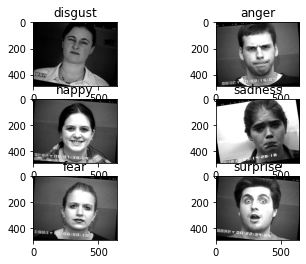

In [4]:
path = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+_Complete'

for index, directory_name in enumerate(os.listdir(path)):
    joined_directory = os.path.join(path, directory_name)
    sample_image = random.choice(os.listdir(joined_directory))
    print(sample_image)
    image = PIL.Image.open(os.path.join(joined_directory, sample_image)).convert('I')
    plt.subplot(3, 2, index + 1)
    plt.title(directory_name)
    plt.imshow(image)

### Printing of dataframe to show matching labels

In [5]:

#load all the data
def get_all_file_paths(path):
    all_filenames = []
    for root, subdirs, files in os.walk(path):
        for name in files:
            absolute_filepath = os.path.join(root, name)
            relative_file_path = os.path.join(os.path.basename(root), name)
            all_filenames.append(relative_file_path)
            # print(name)
    return all_filenames


def get_label(file_name):
    if 'angry' in str(file_name):
        return 0
    if 'disgust' in str(file_name):
        return 1
    if 'fear' in str(file_name):
        return 2
    if 'happy' in str(file_name):
        return 3
    if 'sad' in str(file_name):
        return 4
    if 'surprise' in str(file_name):
        return 5


categories = []

filenames = get_all_file_paths(path)
# use list() to show all the values inside a list
# print(list(filenames))
# randomize the files
random.shuffle(filenames)
for filename in filenames:
    categories.append(get_label(filename))
# print(list(categories))

# join the filename and categories list together

dataframe = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


<AxesSubplot: >

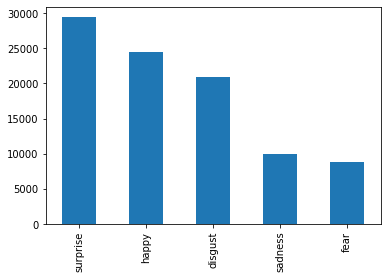

In [6]:
dataframe["category"] = dataframe["category"].replace(
    {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sadness', 5: 'surprise', })
dataframe['category'].value_counts().plot.bar()

### Training and Testing Models

Code implementation for each modes is the same throughout the experiment.
<br>Thus, only the first model contains information and comments about the implmentation.
<br>Simply need to change the variables 'path', 'MODEL_NAME' for each models
<br>
<br>To avoid overfitting, early-stopping feature is implemented to stop the training 

## ====No Pre-Processing=====

Training the basic model with Dataset1 
Testing with basic test set 1

In [7]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CK_s1'
dataset_2_folder_name = 'CK_s2'
dataset_3_folder_name = 'CK_s3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

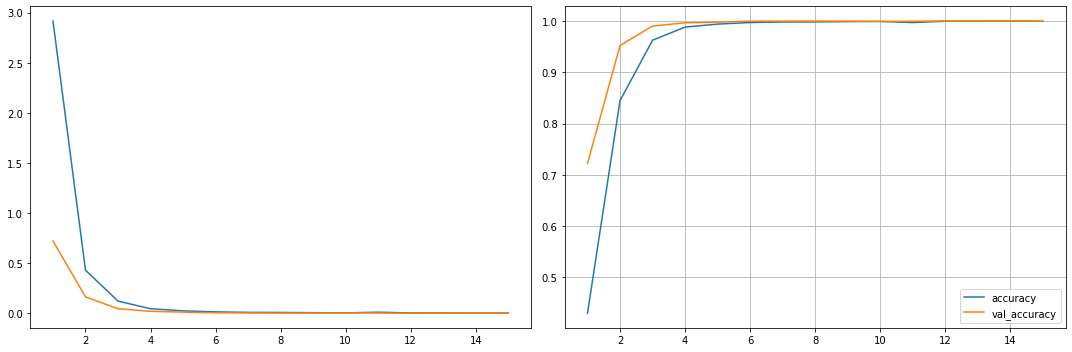

142/142 [==============================] - 45s 307ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0011 - val_accuracy: 0.9997


In [8]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
# prints summary of our model.
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

# monitor	Quantity to be monitored.
# patience	Number of epochs with no improvement after which training will be stopped.
# verbose	Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
# mode	One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 102s 2s/step
              precision    recall  f1-score   support

       anger       0.20      0.18      0.19      3195
     disgust       0.38      0.32      0.35      4260
        fear       0.11      0.15      0.12      1775
       happy       0.84      0.58      0.69      4970
     sadness       0.12      0.31      0.17      1420
    surprise       0.73      0.67      0.70      5680

    accuracy                           0.44     21300
   macro avg       0.40      0.37      0.37     21300
weighted avg       0.51      0.44      0.47     21300



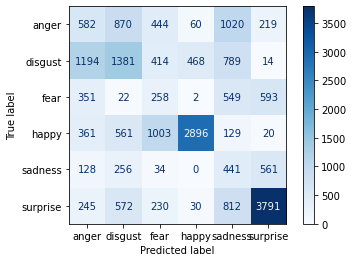

In [9]:
# WEIGHT_NAME = "1_basic_d1.h5"

test_dir = os.path.join(project_folder_name, folder_type[1])
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset2

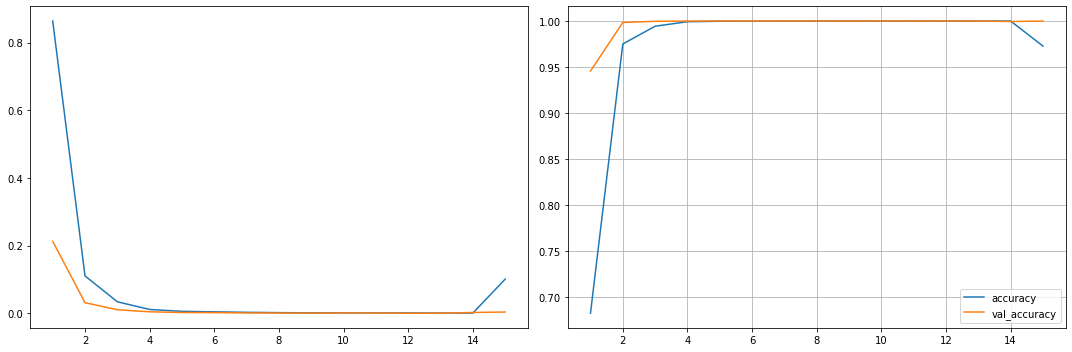

141/141 [==============================] - 47s 321ms/step - loss: 0.1008 - accuracy: 0.9728 - val_loss: 0.0036 - val_accuracy: 0.9999


In [10]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])
NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 94s 2s/step
              precision    recall  f1-score   support

       anger       0.24      0.59      0.34      3195
     disgust       0.50      0.32      0.39      4260
        fear       0.19      0.26      0.22      1775
       happy       0.80      0.47      0.59      4970
     sadness       0.03      0.01      0.01      1775
    surprise       0.62      0.56      0.59      5680

    accuracy                           0.43     21655
   macro avg       0.40      0.37      0.36     21655
weighted avg       0.50      0.43      0.44     21655



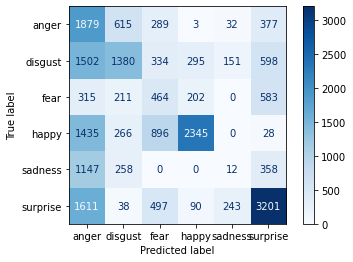

In [11]:
# WEIGHT_NAME = '1_basic_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset3

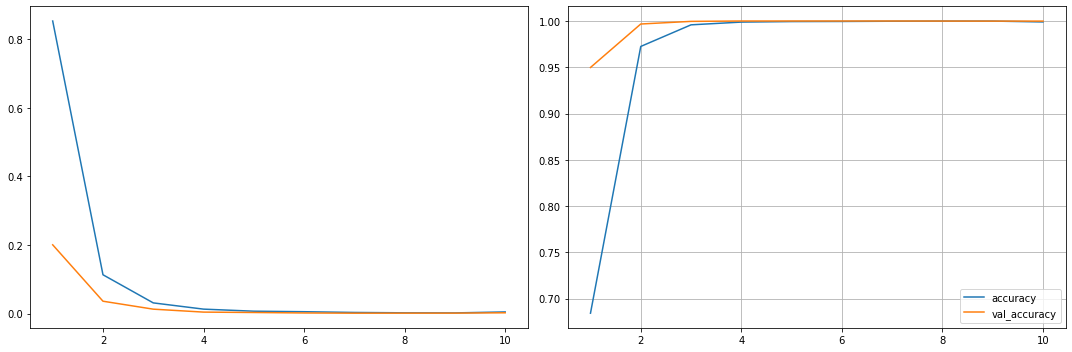

141/141 [==============================] - 46s 315ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0021 - val_accuracy: 0.9999


In [12]:

path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 99s 2s/step
              precision    recall  f1-score   support

       anger       0.52      0.11      0.18      3195
     disgust       0.44      0.70      0.54      4260
        fear       0.00      0.00      0.00      1775
       happy       0.72      0.72      0.72      4970
     sadness       0.49      0.51      0.50      1775
    surprise       0.72      0.88      0.79      5680

    accuracy                           0.59     21655
   macro avg       0.48      0.49      0.46     21655
weighted avg       0.56      0.59      0.55     21655



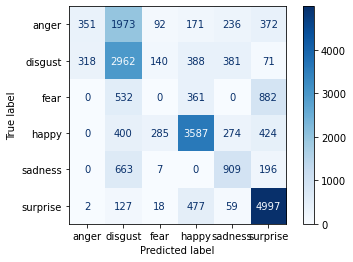

In [13]:
# WEIGHT_NAME = '1_basic_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


### ====Image Cropping====

Training and Testing on the image cropping model with Dataset1

In [14]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_Cropping_1'
dataset_2_folder_name = 'CKD_Cropping_2'
dataset_3_folder_name = 'CKD_Cropping_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

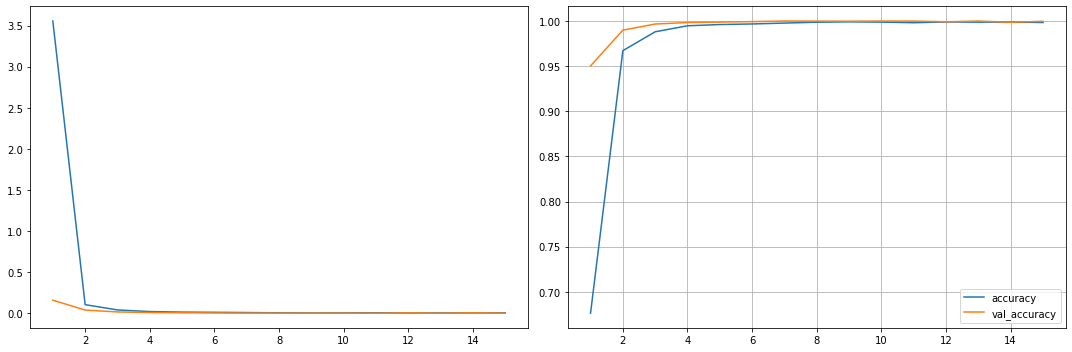

142/142 [==============================] - 16s 108ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0014 - val_accuracy: 0.9995


In [15]:


path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 107s 2s/step
              precision    recall  f1-score   support

       anger       0.52      0.29      0.37      3195
     disgust       0.14      0.10      0.12      4260
        fear       0.00      0.00      0.00      1775
       happy       0.35      0.14      0.20      4970
     sadness       0.18      0.15      0.16      1420
    surprise       0.36      0.83      0.50      5680

    accuracy                           0.33     21300
   macro avg       0.26      0.25      0.22     21300
weighted avg       0.30      0.33      0.27     21300



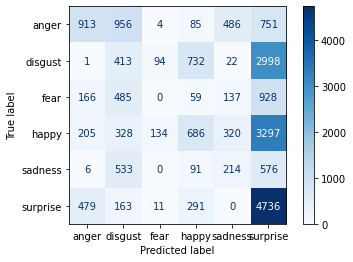

In [16]:
# WEIGHT_NAME = '1_crop_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the image cropping model with Dataset2

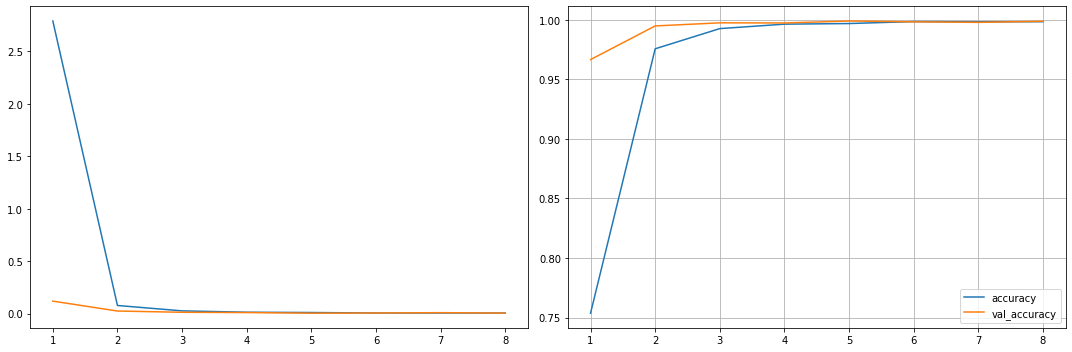

141/141 [==============================] - 15s 106ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.0053 - val_accuracy: 0.9988


In [17]:

path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 94s 2s/step
              precision    recall  f1-score   support

       anger       0.12      0.07      0.09      3195
     disgust       0.12      0.04      0.06      4260
        fear       0.04      0.05      0.04      1775
       happy       0.24      0.24      0.24      4970
     sadness       0.30      0.17      0.21      1775
    surprise       0.25      0.45      0.32      5680

    accuracy                           0.21     21655
   macro avg       0.18      0.17      0.16     21655
weighted avg       0.19      0.21      0.18     21655



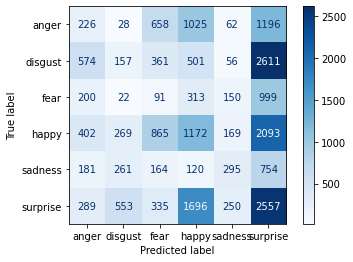

In [18]:
# WEIGHT_NAME = '1_crop_d2.h5'

#Fetch testing data from the dataset2
test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset3

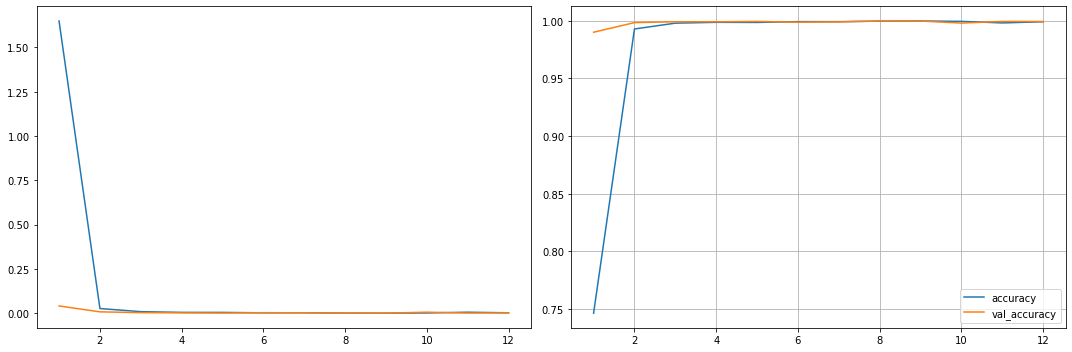

141/141 [==============================] - 16s 110ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0024 - val_accuracy: 0.9994


In [19]:

path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 100s 2s/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.05      0.01      0.01      4260
        fear       0.01      0.01      0.01      1775
       happy       0.42      0.11      0.17      4970
     sadness       0.09      0.13      0.11      1775
    surprise       0.25      0.69      0.36      5680

    accuracy                           0.22     21655
   macro avg       0.14      0.16      0.11     21655
weighted avg       0.18      0.22      0.15     21655



/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


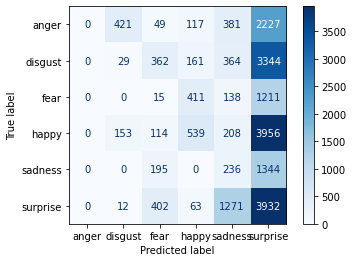

In [20]:
# WEIGHT_NAME = '1_crop_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## ====Intensity Normalization====

Training and Testing on the Intensity Normalization model with Dataset1

In [21]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_IntentNorm_1'
dataset_2_folder_name = 'CKD_IntentNorm_2'
dataset_3_folder_name = 'CKD_IntentNorm_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

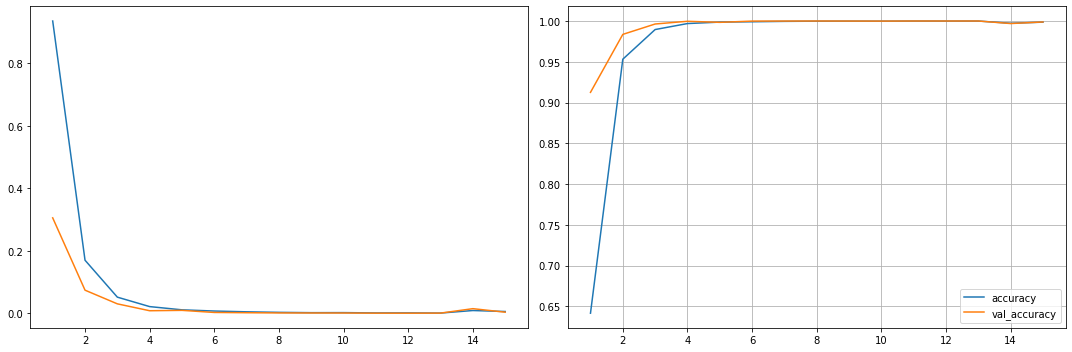

142/142 [==============================] - 16s 110ms/step - loss: 0.0057 - accuracy: 0.9986 - val_loss: 0.0036 - val_accuracy: 0.9988


In [22]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 101s 2s/step
              precision    recall  f1-score   support

       anger       0.22      0.19      0.21      3195
     disgust       0.21      0.25      0.23      4260
        fear       0.03      0.02      0.02      1775
       happy       0.68      0.82      0.74      4970
     sadness       0.40      0.73      0.52      1420
    surprise       0.91      0.64      0.75      5680

    accuracy                           0.49     21300
   macro avg       0.41      0.44      0.41     21300
weighted avg       0.51      0.49      0.49     21300



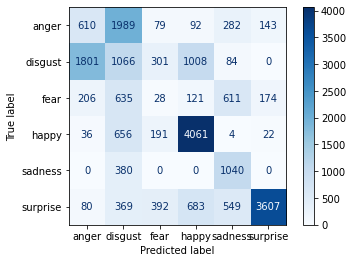

In [23]:
# WEIGHT_NAME = '1_IN_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Intensity Normalization model with Dataset2

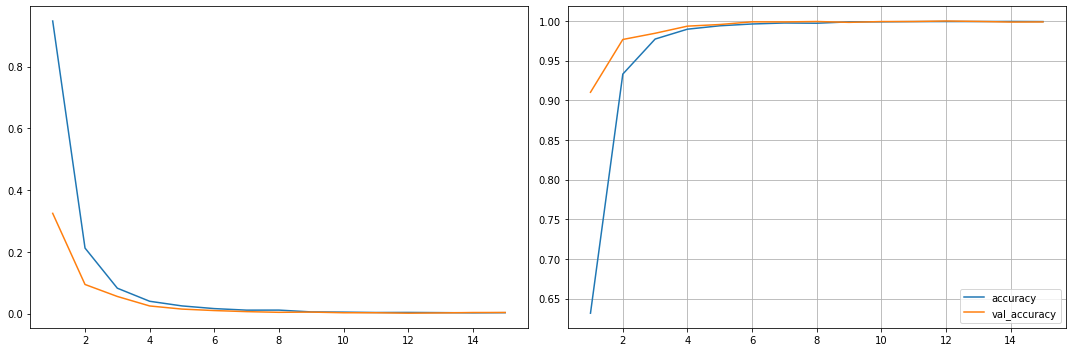

141/141 [==============================] - 16s 111ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0036 - val_accuracy: 0.9988


In [24]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 93s 2s/step
              precision    recall  f1-score   support

       anger       0.20      0.71      0.31      3195
     disgust       0.59      0.35      0.44      4260
        fear       0.07      0.04      0.05      1775
       happy       0.77      0.35      0.48      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.77      0.54      0.64      5680

    accuracy                           0.40     21655
   macro avg       0.40      0.33      0.32     21655
weighted avg       0.53      0.40      0.41     21655



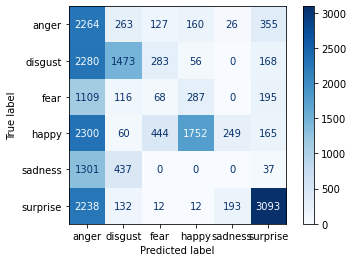

In [25]:
# WEIGHT_NAME = '1_IN_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

We are here

Training and Testing on the Intensity Normalization model with Dataset3

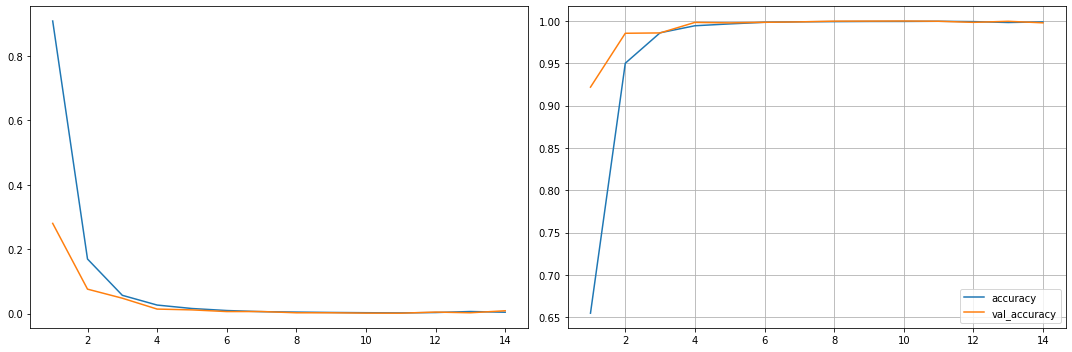

141/141 [==============================] - 16s 110ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0088 - val_accuracy: 0.9978


In [26]:
path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 98s 2s/step
              precision    recall  f1-score   support

       anger       0.46      0.06      0.11      3195
     disgust       0.37      0.80      0.51      4260
        fear       0.00      0.00      0.00      1775
       happy       0.73      0.78      0.75      4970
     sadness       0.84      0.15      0.26      1775
    surprise       0.76      0.84      0.80      5680

    accuracy                           0.58     21655
   macro avg       0.53      0.44      0.40     21655
weighted avg       0.58      0.58      0.52     21655



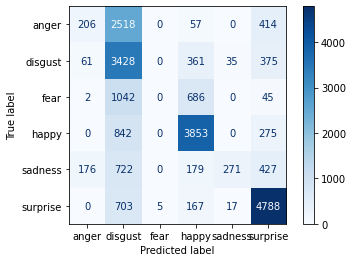

In [27]:
# WEIGHT_NAME = '1_IN_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## ====Image Cropping and Intensity Normalization====

Training and Testing on the Cropping and Intensity Normalization model with Dataset1

In [28]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_Crop_IntentNorm_1'
dataset_2_folder_name = 'CKD_Crop_IntentNorm_2'
dataset_3_folder_name = 'CKD_Crop_IntentNorm_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

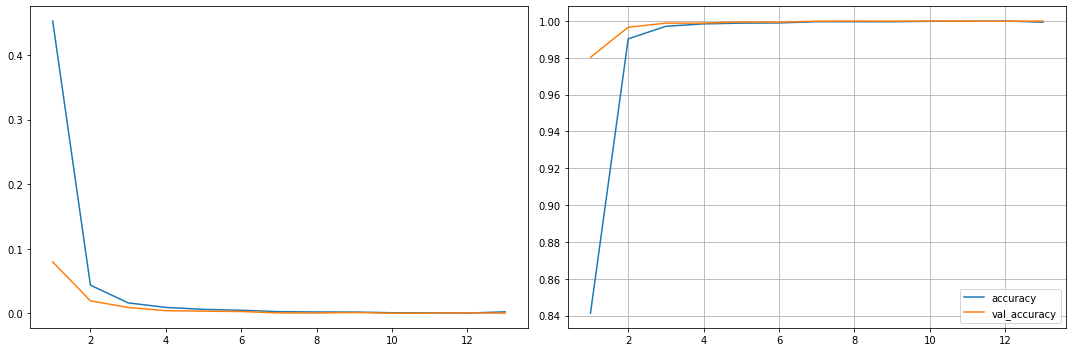

142/142 [==============================] - 10s 66ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 4.3760e-04 - val_accuracy: 0.9999


In [29]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = '1_CR_IN_d1.h5'

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 101s 2s/step
              precision    recall  f1-score   support

       anger       0.02      0.00      0.00      3195
     disgust       0.43      0.44      0.44      4260
        fear       0.00      0.00      0.00      1775
       happy       0.25      0.15      0.19      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.30      0.58      0.40      5680

    accuracy                           0.28     21300
   macro avg       0.17      0.20      0.17     21300
weighted avg       0.23      0.28      0.24     21300



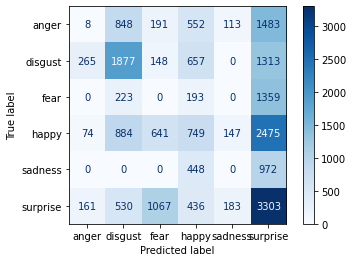

In [30]:
# WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Cropping and Intensity Normalization model with Dataset2

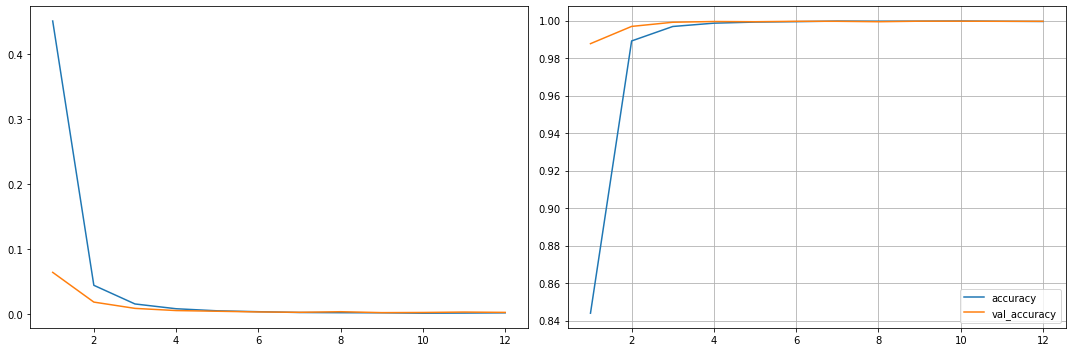

141/141 [==============================] - 10s 67ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0024 - val_accuracy: 0.9997


In [31]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = '1_CR_IN_d2.h5'

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 93s 2s/step
              precision    recall  f1-score   support

       anger       0.02      0.01      0.01      3195
     disgust       0.28      0.34      0.31      4260
        fear       0.03      0.08      0.05      1775
       happy       0.23      0.13      0.17      4970
     sadness       0.25      0.18      0.21      1775
    surprise       0.33      0.41      0.37      5680

    accuracy                           0.23     21655
   macro avg       0.19      0.19      0.18     21655
weighted avg       0.22      0.23      0.22     21655



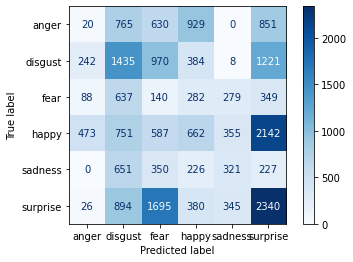

In [32]:
# WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Cropping and Intensity Normalization model with Dataset3


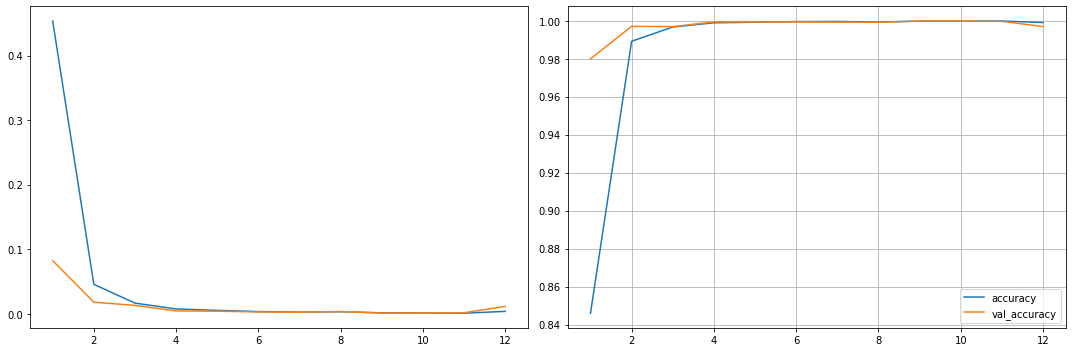

141/141 [==============================] - 10s 68ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0113 - val_accuracy: 0.9969


In [33]:
path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_CR_IN_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 98s 2s/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.15      0.07      0.09      4260
        fear       0.00      0.00      0.00      1775
       happy       0.29      0.47      0.36      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.28      0.53      0.37      5680

    accuracy                           0.26     21655
   macro avg       0.12      0.18      0.14     21655
weighted avg       0.17      0.26      0.20     21655



/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


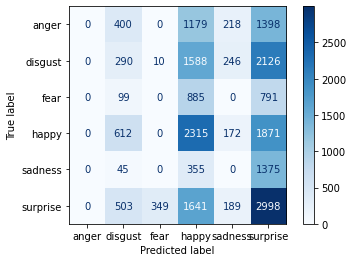

In [34]:
# WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## ====Testing with Pre-Processed Images====


Model structure to run in order to load weights

In [3]:

IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

## Testing with Normalized images


Take the model trained with no pre-processed images<br>
Test with normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 196s 5s/step
              precision    recall  f1-score   support

       anger       0.26      0.19      0.22      3195
     disgust       0.24      0.24      0.24      4260
        fear       0.01      0.01      0.01      1775
       happy       0.46      0.38      0.41      4970
     sadness       0.20      0.25      0.23      1420
    surprise       0.56      0.56      0.56      5680

    accuracy                           0.33     21300
   macro avg       0.29      0.27      0.28     21300
weighted avg       0.36      0.33      0.34     21300



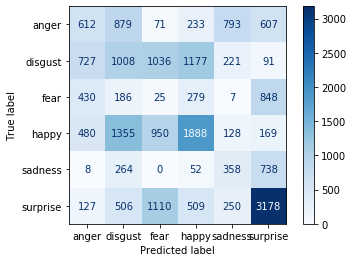

In [6]:
WEIGHT_NAME = '1_basic_d1.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2<br>

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 95s 2s/step
              precision    recall  f1-score   support

       anger       0.21      0.48      0.29      3195
     disgust       0.45      0.05      0.09      4260
        fear       0.14      0.48      0.21      1775
       happy       0.60      0.35      0.44      4970
     sadness       0.11      0.02      0.03      1775
    surprise       0.69      0.59      0.64      5680

    accuracy                           0.35     21655
   macro avg       0.37      0.33      0.28     21655
weighted avg       0.46      0.35      0.35     21655



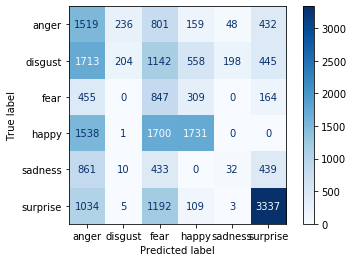

In [7]:
WEIGHT_NAME = '1_basic_d2.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3<br>

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 87s 2s/step
              precision    recall  f1-score   support

       anger       0.15      0.02      0.03      3195
     disgust       0.29      0.07      0.12      4260
        fear       0.09      0.21      0.13      1775
       happy       0.29      0.63      0.40      4970
     sadness       0.54      0.30      0.38      1775
    surprise       0.74      0.59      0.66      5680

    accuracy                           0.36     21655
   macro avg       0.35      0.30      0.29     21655
weighted avg       0.39      0.36      0.33     21655



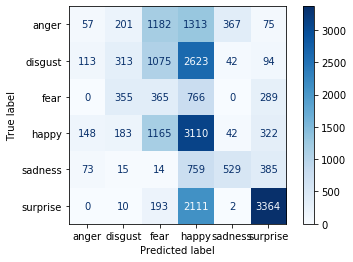

In [8]:
WEIGHT_NAME = '1_basic_d3.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped images<br>
Test with normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 2385s 57s/step
              precision    recall  f1-score   support

       anger       0.17      0.00      0.00      3195
     disgust       0.07      0.06      0.07      4260
        fear       0.00      0.00      0.00      1775
       happy       0.31      0.27      0.29      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.38      0.88      0.53      5680

    accuracy                           0.31     21300
   macro avg       0.16      0.20      0.15     21300
weighted avg       0.21      0.31      0.22     21300



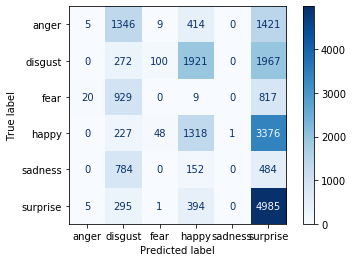

In [9]:
WEIGHT_NAME = '1_crop_d1.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 6357s 148s/step
              precision    recall  f1-score   support

       anger       0.15      0.10      0.12      3195
     disgust       0.30      0.08      0.13      4260
        fear       0.02      0.02      0.02      1775
       happy       0.27      0.25      0.26      4970
     sadness       0.53      0.07      0.12      1775
    surprise       0.25      0.54      0.35      5680

    accuracy                           0.24     21655
   macro avg       0.25      0.18      0.17     21655
weighted avg       0.25      0.24      0.21     21655



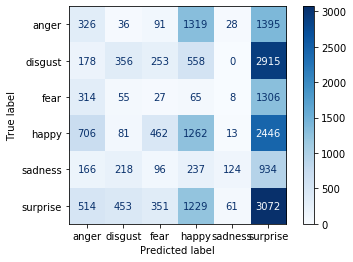

In [10]:
WEIGHT_NAME = '1_crop_d2.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 94s 2s/step
              precision    recall  f1-score   support

       anger       0.08      0.00      0.01      3195
     disgust       0.54      0.02      0.05      4260
        fear       0.01      0.00      0.00      1775
       happy       0.27      0.21      0.23      4970
     sadness       0.28      0.10      0.15      1775
    surprise       0.28      0.80      0.41      5680

    accuracy                           0.27     21655
   macro avg       0.24      0.19      0.14     21655
weighted avg       0.27      0.27      0.18     21655



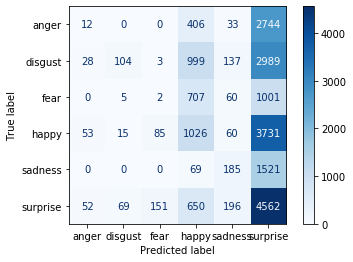

In [11]:
EIGHT_NAME = '1_crop_d3.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with normalized images<br>
Test with normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 82s 2s/step
              precision    recall  f1-score   support

       anger       0.22      0.21      0.22      3195
     disgust       0.18      0.11      0.14      4260
        fear       0.02      0.02      0.02      1775
       happy       0.67      0.47      0.55      4970
     sadness       0.17      0.57      0.26      1420
    surprise       0.79      0.72      0.76      5680

    accuracy                           0.40     21300
   macro avg       0.34      0.35      0.32     21300
weighted avg       0.45      0.40      0.41     21300



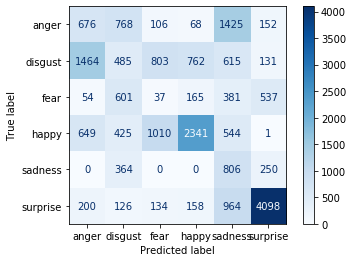

In [12]:
WEIGHT_NAME = '1_IN_d1.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 96s 2s/step
              precision    recall  f1-score   support

       anger       0.23      0.82      0.36      3195
     disgust       0.41      0.18      0.25      4260
        fear       0.16      0.20      0.18      1775
       happy       0.63      0.20      0.30      4970
     sadness       0.13      0.00      0.01      1775
    surprise       0.63      0.52      0.57      5680

    accuracy                           0.35     21655
   macro avg       0.37      0.32      0.28     21655
weighted avg       0.45      0.35      0.34     21655



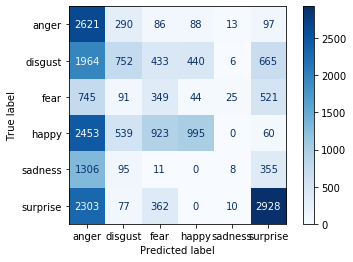

In [13]:
WEIGHT_NAME = '1_IN_d2.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 91s 2s/step
              precision    recall  f1-score   support

       anger       0.22      0.04      0.06      3195
     disgust       0.25      0.49      0.34      4260
        fear       0.44      0.06      0.10      1775
       happy       0.42      0.52      0.46      4970
     sadness       0.51      0.18      0.26      1775
    surprise       0.72      0.75      0.73      5680

    accuracy                           0.43     21655
   macro avg       0.42      0.34      0.33     21655
weighted avg       0.44      0.43      0.40     21655



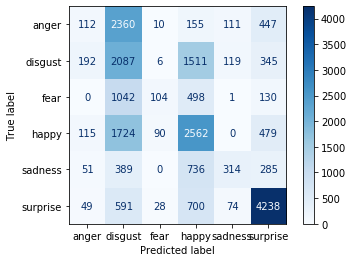

In [14]:
WEIGHT_NAME = '1_IN_d3.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped and normalized images<br>
Test with normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 83s 2s/step
              precision    recall  f1-score   support

       anger       0.02      0.01      0.01      3195
     disgust       0.34      0.45      0.39      4260
        fear       0.00      0.00      0.00      1775
       happy       0.33      0.24      0.28      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.31      0.54      0.39      5680

    accuracy                           0.29     21300
   macro avg       0.17      0.21      0.18     21300
weighted avg       0.23      0.29      0.25     21300



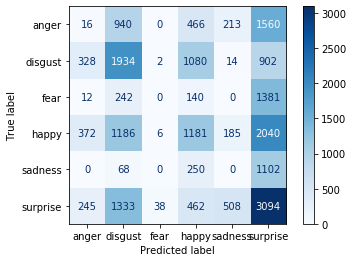

In [15]:
WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 92s 2s/step
              precision    recall  f1-score   support

       anger       0.13      0.10      0.11      3195
     disgust       0.20      0.30      0.24      4260
        fear       0.01      0.01      0.01      1775
       happy       0.23      0.06      0.09      4970
     sadness       0.24      0.21      0.23      1775
    surprise       0.28      0.42      0.33      5680

    accuracy                           0.21     21655
   macro avg       0.18      0.18      0.17     21655
weighted avg       0.21      0.21      0.19     21655



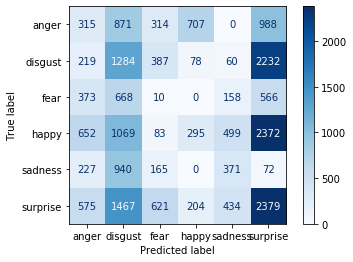

In [16]:
WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 92s 2s/step


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.23      0.06      0.10      4260
        fear       0.00      0.00      0.00      1775
       happy       0.31      0.48      0.38      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.32      0.65      0.43      5680

    accuracy                           0.29     21655
   macro avg       0.14      0.20      0.15     21655
weighted avg       0.20      0.29      0.22     21655



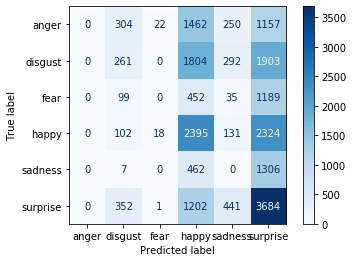

In [17]:
WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = '/Users/mantagaori/Desktop/Test_IN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# START RUNNING FROM HERE

## Testing with cropped images


Take the model trained with no pre-processing<br>
Test with cropped images<br><br>
Dataset 1

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 110s 3s/step
              precision    recall  f1-score   support

       anger       0.17      0.03      0.05      3195
     disgust       0.04      0.00      0.01      4260
        fear       0.05      0.22      0.08      1775
       happy       0.00      0.00      0.00      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.28      0.59      0.38      5680

    accuracy                           0.18     21300
   macro avg       0.09      0.14      0.09     21300
weighted avg       0.11      0.18      0.12     21300



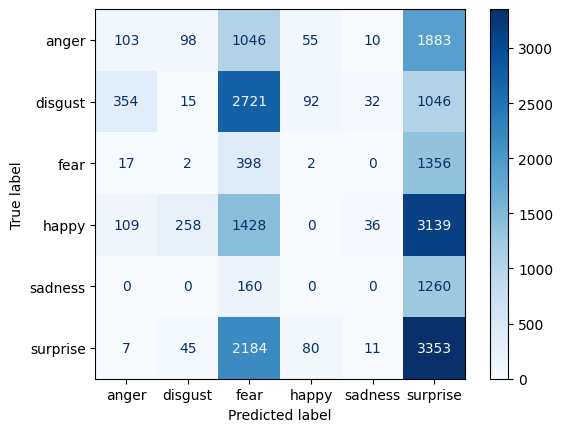

In [6]:
WEIGHT_NAME = '1_basic_d1.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 109s 3s/step
              precision    recall  f1-score   support

       anger       0.22      0.04      0.07      3195
     disgust       0.67      0.00      0.00      4260
        fear       0.09      0.60      0.16      1775
       happy       0.03      0.00      0.00      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.25      0.40      0.31      5680

    accuracy                           0.16     21655
   macro avg       0.21      0.17      0.09     21655
weighted avg       0.24      0.16      0.10     21655



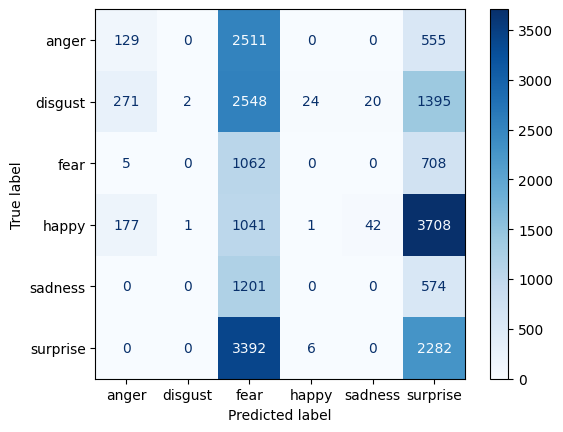

In [7]:
WEIGHT_NAME = '1_basic_d2.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 146s 3s/step


c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.00      0.00      0.00      4260
        fear       0.16      0.43      0.23      1775
       happy       0.00      0.00      0.00      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.32      0.95      0.48      5680

    accuracy                           0.28     21655
   macro avg       0.08      0.23      0.12     21655
weighted avg       0.10      0.28      0.14     21655



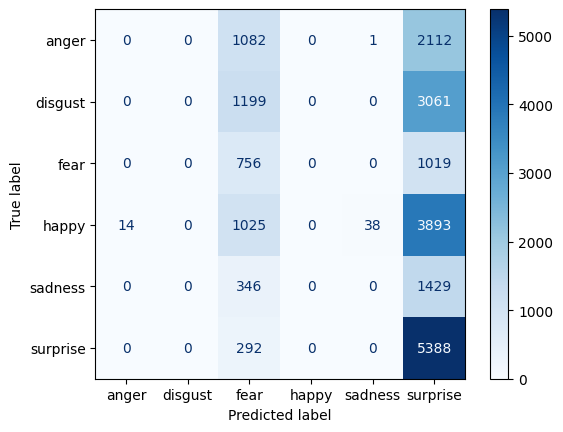

In [8]:
WEIGHT_NAME = '1_basic_d3.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped image<br>
Test with cropped images<br><br>
Dataset 1

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 28s 649ms/step
              precision    recall  f1-score   support

       anger       0.70      0.33      0.45      3195
     disgust       0.88      0.91      0.89      4260
        fear       0.70      0.32      0.44      1775
       happy       0.95      0.97      0.96      4970
     sadness       0.34      1.00      0.51      1420
    surprise       0.95      0.89      0.92      5680

    accuracy                           0.79     21300
   macro avg       0.75      0.74      0.70     21300
weighted avg       0.84      0.79      0.79     21300



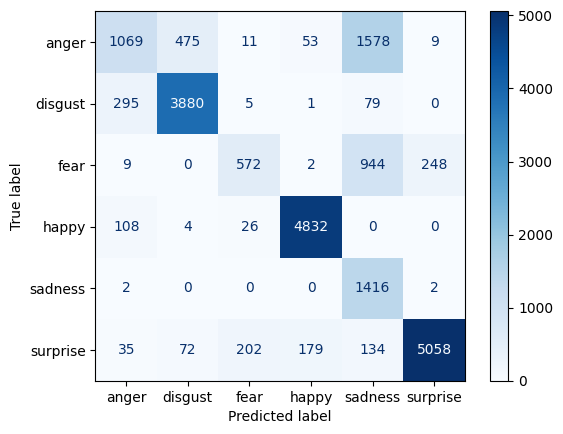

In [9]:
WEIGHT_NAME = '1_crop_d1.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 26s 585ms/step
              precision    recall  f1-score   support

       anger       0.73      0.80      0.76      3195
     disgust       0.84      0.85      0.84      4260
        fear       0.72      0.17      0.27      1775
       happy       0.84      0.98      0.90      4970
     sadness       0.76      0.56      0.64      1775
    surprise       0.82      0.92      0.86      5680

    accuracy                           0.81     21655
   macro avg       0.78      0.71      0.72     21655
weighted avg       0.80      0.81      0.79     21655



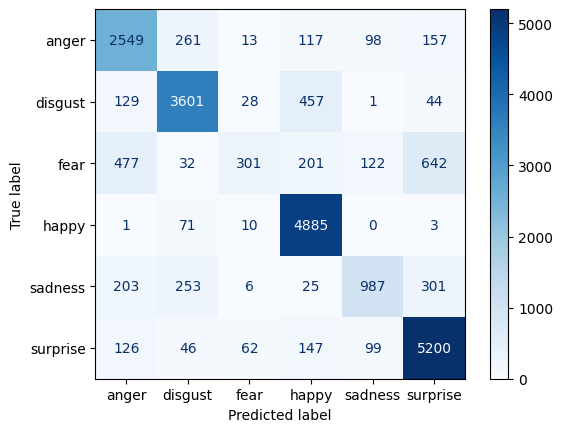

In [10]:
WEIGHT_NAME = '1_crop_d2.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 273s 6s/step
              precision    recall  f1-score   support

       anger       0.93      0.85      0.89      3195
     disgust       0.94      0.98      0.96      4260
        fear       0.90      0.66      0.76      1775
       happy       0.98      0.97      0.97      4970
     sadness       0.77      0.93      0.85      1775
    surprise       0.93      0.96      0.95      5680

    accuracy                           0.93     21655
   macro avg       0.91      0.89      0.90     21655
weighted avg       0.93      0.93      0.92     21655



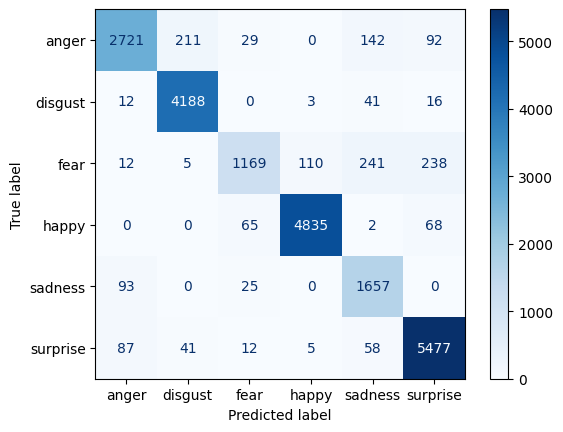

In [11]:
WEIGHT_NAME = '1_crop_d3.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with normalized images<br>
Test with cropped images<br><br>
Dataset 1

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 448s 11s/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.00      0.00      0.00      4260
        fear       0.00      0.00      0.00      1775
       happy       0.25      0.07      0.10      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.28      0.99      0.44      5680

    accuracy                           0.28     21300
   macro avg       0.09      0.18      0.09     21300
weighted avg       0.13      0.28      0.14     21300



c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

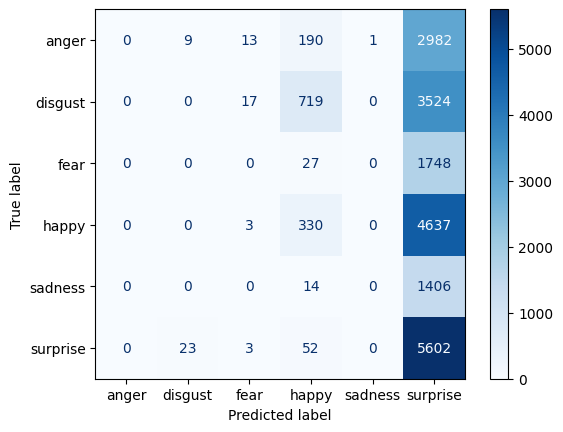

In [12]:
WEIGHT_NAME = '1_IN_d1.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 25s 572ms/step
              precision    recall  f1-score   support

       anger       0.29      0.03      0.05      3195
     disgust       0.00      0.00      0.00      4260
        fear       0.07      0.31      0.11      1775
       happy       0.17      0.02      0.04      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.33      0.73      0.45      5680

    accuracy                           0.23     21655
   macro avg       0.14      0.18      0.11     21655
weighted avg       0.17      0.23      0.14     21655



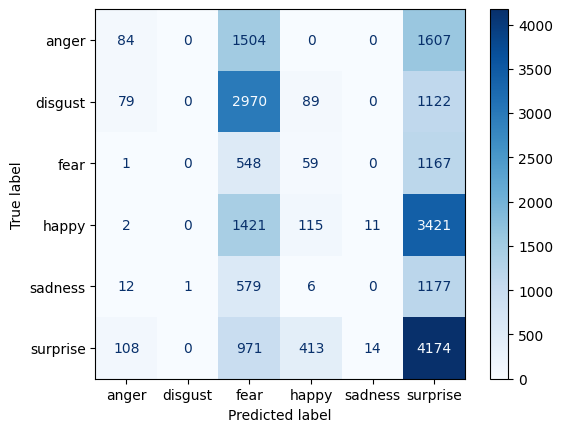

In [31]:
WEIGHT_NAME = '1_IN_d2.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 27s 609ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.60      0.00      0.00      4260
        fear       0.00      0.00      0.00      1775
       happy       0.07      0.01      0.02      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.28      0.99      0.43      5680

    accuracy                           0.26     21655
   macro avg       0.16      0.17      0.08     21655
weighted avg       0.21      0.26      0.12     21655



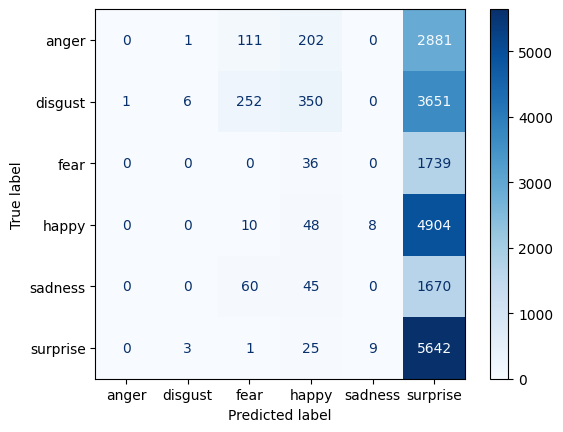

In [33]:
WEIGHT_NAME = '1_IN_d3.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped and normalized images<br>
Test with cropped images<br><br>
Dataset 1

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 28s 643ms/step
              precision    recall  f1-score   support

       anger       0.54      0.71      0.61      3195
     disgust       0.90      0.86      0.88      4260
        fear       0.99      0.37      0.54      1775
       happy       1.00      0.97      0.98      4970
     sadness       0.50      0.57      0.53      1420
    surprise       0.86      0.89      0.87      5680

    accuracy                           0.81     21300
   macro avg       0.80      0.73      0.74     21300
weighted avg       0.84      0.81      0.81     21300



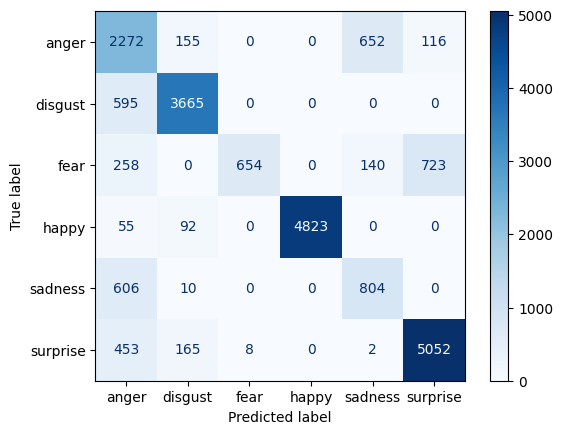

In [15]:
WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 25s 558ms/step
              precision    recall  f1-score   support

       anger       0.53      0.86      0.66      3195
     disgust       0.82      0.67      0.74      4260
        fear       0.84      0.31      0.45      1775
       happy       0.78      0.88      0.83      4970
     sadness       0.46      0.38      0.41      1775
    surprise       0.91      0.84      0.87      5680

    accuracy                           0.74     21655
   macro avg       0.72      0.66      0.66     21655
weighted avg       0.76      0.74      0.73     21655



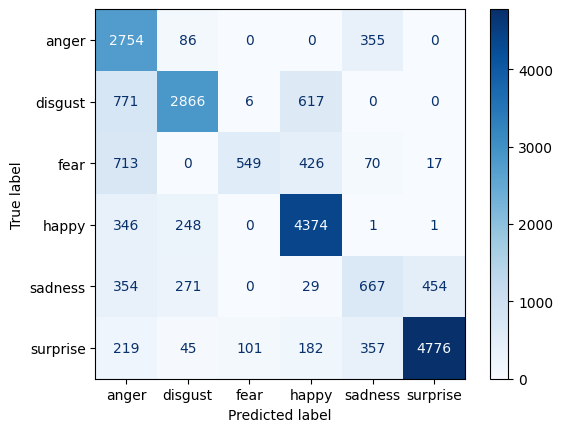

In [16]:
WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 26s 599ms/step
              precision    recall  f1-score   support

       anger       0.95      0.95      0.95      3195
     disgust       0.99      1.00      0.99      4260
        fear       0.98      0.52      0.68      1775
       happy       0.98      0.99      0.99      4970
     sadness       0.96      0.98      0.97      1775
    surprise       0.88      0.99      0.93      5680

    accuracy                           0.95     21655
   macro avg       0.96      0.90      0.92     21655
weighted avg       0.95      0.95      0.94     21655



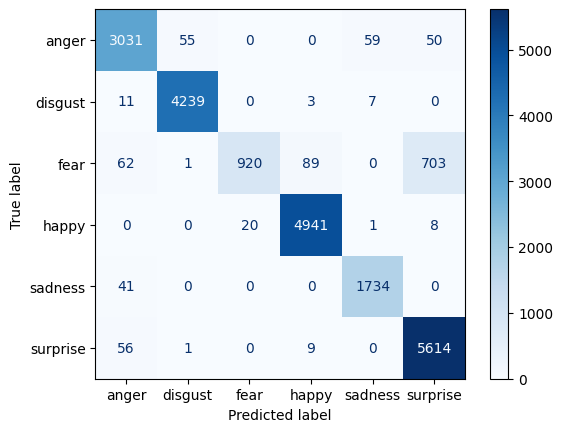

In [17]:
WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = 'D:\Concordia\COMP473\Test_crop3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Testing with Cropped and Normalized images


Take the model trained with no pre-processed images<br>
Test with cropped and normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 117s 3s/step
              precision    recall  f1-score   support

       anger       0.12      0.14      0.13      3195
     disgust       0.00      0.00      0.00      4260
        fear       0.07      0.32      0.11      1775
       happy       0.59      0.17      0.26      4970
     sadness       0.03      0.00      0.01      1420
    surprise       0.29      0.40      0.34      5680

    accuracy                           0.19     21300
   macro avg       0.18      0.17      0.14     21300
weighted avg       0.24      0.19      0.18     21300



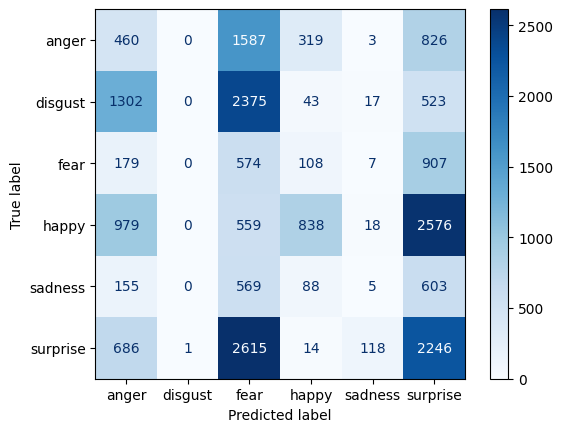

In [18]:
WEIGHT_NAME = '1_basic_d1.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 154s 4s/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.00      0.00      0.00      4260
        fear       0.07      0.60      0.13      1775
       happy       0.25      0.01      0.01      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.29      0.33      0.31      5680

    accuracy                           0.14     21655
   macro avg       0.10      0.16      0.08     21655
weighted avg       0.14      0.14      0.09     21655



c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

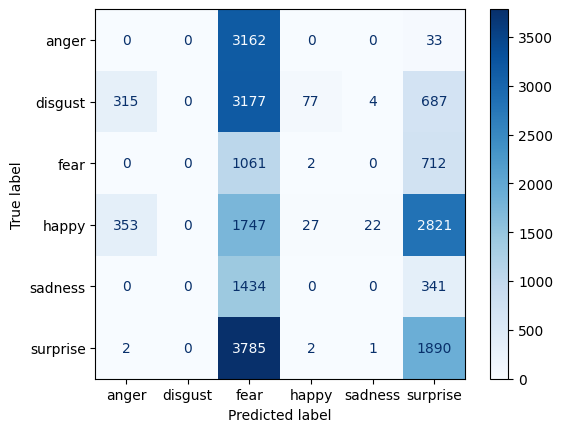

In [19]:
WEIGHT_NAME = '1_basic_d2.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 122s 3s/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.00      0.00      0.00      4260
        fear       0.10      0.41      0.16      1775
       happy       0.00      0.00      0.00      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.35      0.86      0.49      5680

    accuracy                           0.26     21655
   macro avg       0.07      0.21      0.11     21655
weighted avg       0.10      0.26      0.14     21655



c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

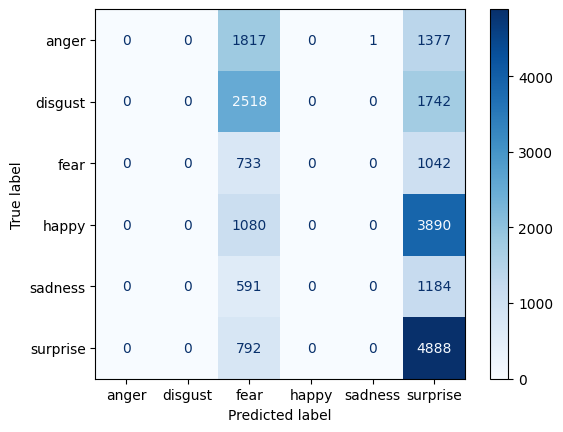

In [20]:
WEIGHT_NAME = '1_basic_d3.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped images<br>
Test with cropped and normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 11s 264ms/step
              precision    recall  f1-score   support

       anger       0.64      0.50      0.56      3195
     disgust       0.58      0.94      0.72      4260
        fear       0.58      0.62      0.60      1775
       happy       0.95      0.62      0.75      4970
     sadness       0.67      0.56      0.61      1420
    surprise       0.87      0.86      0.86      5680

    accuracy                           0.73     21300
   macro avg       0.71      0.68      0.68     21300
weighted avg       0.76      0.73      0.72     21300



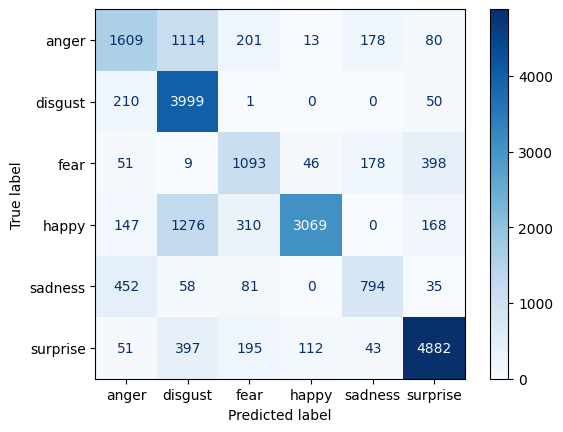

In [21]:
WEIGHT_NAME = '1_crop_d1.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 11s 241ms/step
              precision    recall  f1-score   support

       anger       0.36      0.50      0.42      3195
     disgust       0.56      0.67      0.61      4260
        fear       0.39      0.25      0.30      1775
       happy       0.76      0.84      0.80      4970
     sadness       0.63      0.43      0.51      1775
    surprise       0.80      0.61      0.69      5680

    accuracy                           0.61     21655
   macro avg       0.58      0.55      0.56     21655
weighted avg       0.63      0.61      0.61     21655



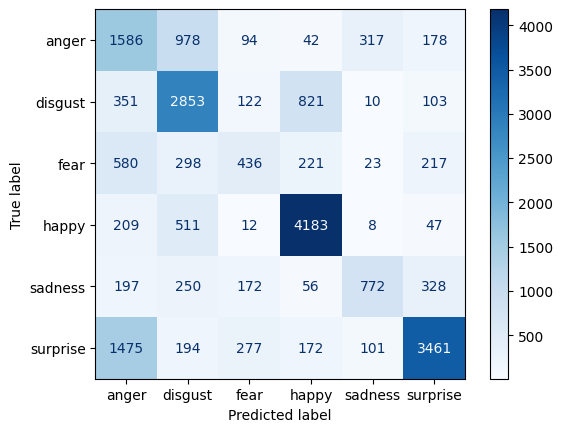

In [22]:
WEIGHT_NAME = '1_crop_d2.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 11s 255ms/step
              precision    recall  f1-score   support

       anger       0.76      0.19      0.31      3195
     disgust       0.99      0.55      0.71      4260
        fear       0.80      0.55      0.65      1775
       happy       0.86      0.99      0.92      4970
     sadness       0.30      1.00      0.47      1775
    surprise       0.89      0.90      0.90      5680

    accuracy                           0.73     21655
   macro avg       0.77      0.70      0.66     21655
weighted avg       0.83      0.73      0.72     21655



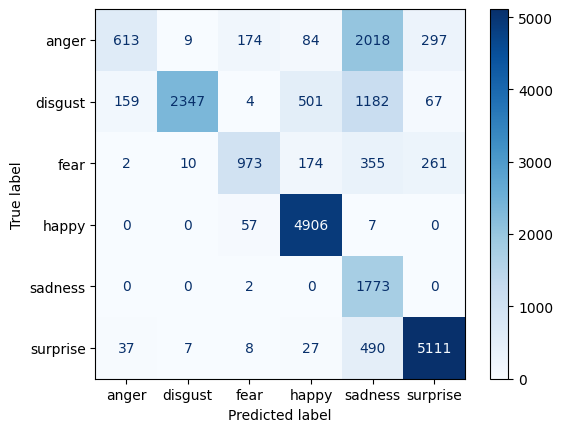

In [23]:
WEIGHT_NAME = '1_crop_d3.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with normalized images<br>
Test with cropped and normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 11s 260ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.00      0.00      0.00      4260
        fear       0.00      0.00      0.00      1775
       happy       0.19      0.07      0.10      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.28      0.95      0.43      5680

    accuracy                           0.27     21300
   macro avg       0.08      0.17      0.09     21300
weighted avg       0.12      0.27      0.14     21300



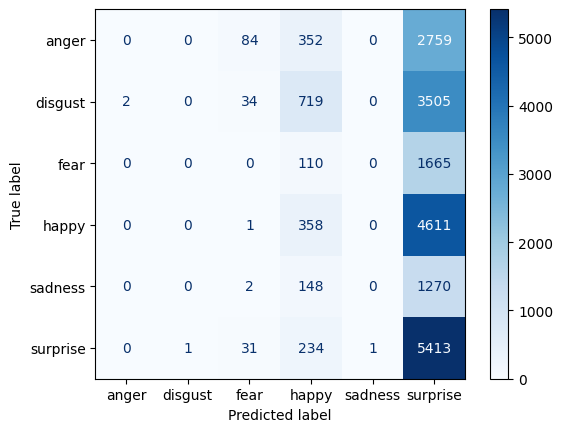

In [24]:
WEIGHT_NAME = '1_IN_d1.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 11s 242ms/step
              precision    recall  f1-score   support

       anger       0.22      0.08      0.11      3195
     disgust       0.00      0.00      0.00      4260
        fear       0.08      0.49      0.13      1775
       happy       0.14      0.02      0.04      4970
     sadness       0.41      0.01      0.02      1775
    surprise       0.39      0.57      0.46      5680

    accuracy                           0.21     21655
   macro avg       0.21      0.19      0.13     21655
weighted avg       0.21      0.21      0.16     21655



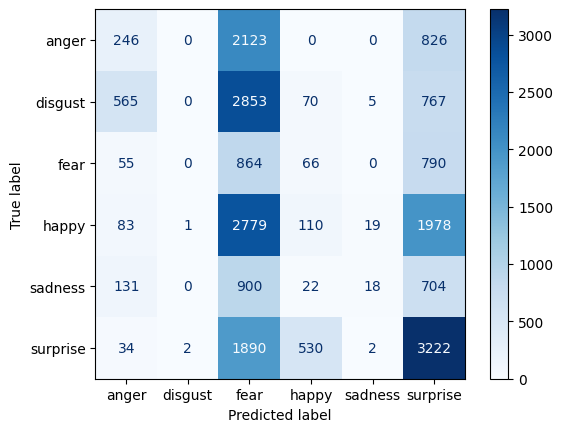

In [25]:
WEIGHT_NAME = '1_IN_d2.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 11s 259ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.50      0.00      0.00      4260
        fear       0.04      0.07      0.05      1775
       happy       0.12      0.02      0.04      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.32      0.97      0.48      5680

    accuracy                           0.27     21655
   macro avg       0.16      0.18      0.09     21655
weighted avg       0.21      0.27      0.14     21655



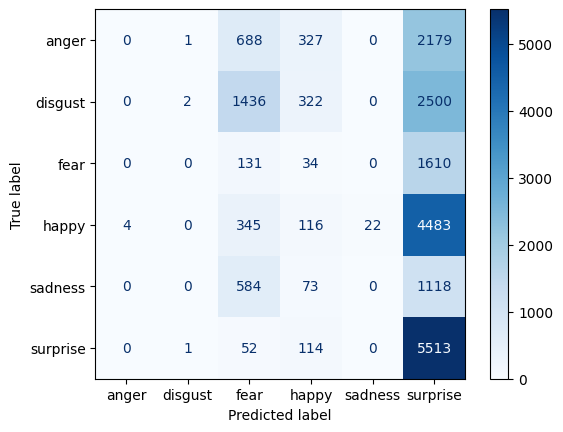

In [26]:
WEIGHT_NAME = '1_IN_d3.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Take the model trained with cropped and normalized images<br>
Test with cropped and normalized images<br><br>
Dataset 1<br>

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 12s 271ms/step
              precision    recall  f1-score   support

       anger       0.59      0.55      0.57      3195
     disgust       0.98      0.89      0.93      4260
        fear       0.81      0.92      0.86      1775
       happy       0.91      0.96      0.94      4970
     sadness       0.44      0.65      0.52      1420
    surprise       0.98      0.88      0.93      5680

    accuracy                           0.84     21300
   macro avg       0.78      0.81      0.79     21300
weighted avg       0.85      0.84      0.84     21300



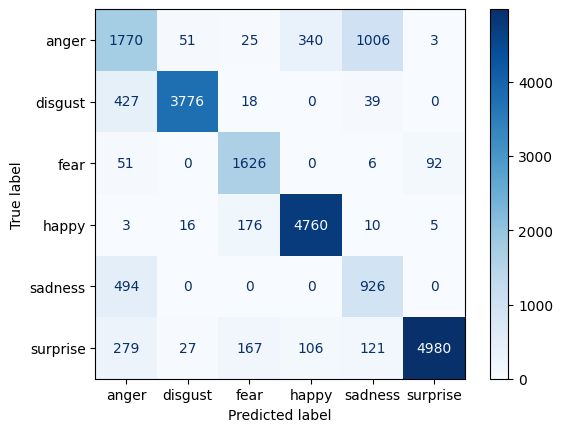

In [27]:
WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN1'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 2

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 11s 245ms/step
              precision    recall  f1-score   support

       anger       0.65      0.88      0.75      3195
     disgust       0.93      0.81      0.86      4260
        fear       0.72      0.50      0.59      1775
       happy       0.88      0.91      0.90      4970
     sadness       0.57      0.69      0.62      1775
    surprise       0.85      0.75      0.80      5680

    accuracy                           0.79     21655
   macro avg       0.76      0.76      0.75     21655
weighted avg       0.81      0.79      0.79     21655



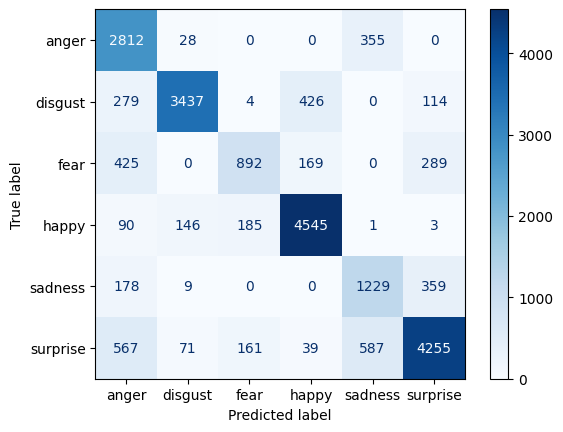

In [28]:
WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN2'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dataset 3

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 11s 260ms/step
              precision    recall  f1-score   support

       anger       0.97      0.68      0.80      3195
     disgust       0.92      0.99      0.95      4260
        fear       0.70      0.51      0.59      1775
       happy       0.98      0.98      0.98      4970
     sadness       0.91      0.99      0.95      1775
    surprise       0.85      0.99      0.91      5680

    accuracy                           0.90     21655
   macro avg       0.89      0.86      0.86     21655
weighted avg       0.90      0.90      0.90     21655



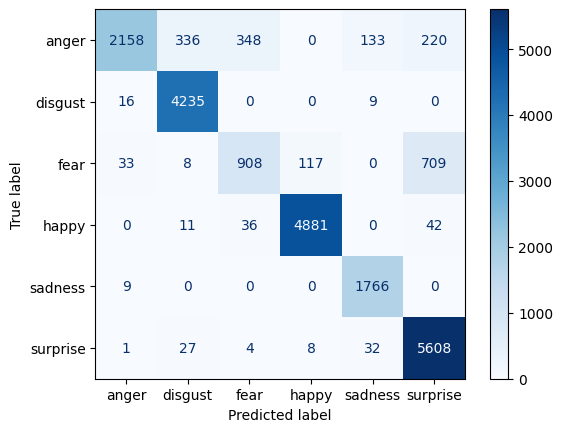

In [29]:
WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = 'D:\Concordia\COMP473\Test_cropIN3'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(WEIGHT_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Testing with JAFFE datasets

In [5]:

project_folder_name = "C:\\Users\\hsad6\\Desktop\\comp473_conda\\myTest"
aug_jaffe_test_dir = "C:\\Users\\hsad6\\Desktop\\comp473_conda\\JAFFE"
inten_jaffe_test_dir = "C:\\Users\\hsad6\\Desktop\\comp473_conda\\JAFFE_Intensity"
crop_jaffe_test_dir = "C:\\Users\\hsad6\\Desktop\\comp473_conda\\JAFFE_Crop"
inten_crop_jaffe_test_dir = "C:\\Users\\hsad6\\Desktop\\comp473_conda\\JAFFE_Intensity_Crop"

In [6]:
NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"


### model trained with No pre-processed images 
tested with no pre-prosessed JAFFE images

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 31s 1s/step


C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.15      0.14      0.14      2130
     disgust       0.20      0.54      0.29      2059
        fear       0.00      0.00      0.00      2272
       happy       0.15      0.33      0.21      2201
     sadness       0.08      0.02      0.04      2201
    surprise       0.17      0.01      0.02      2130

    accuracy                           0.17     12993
   macro avg       0.12      0.17      0.12     12993
weighted avg       0.12      0.17      0.11     12993



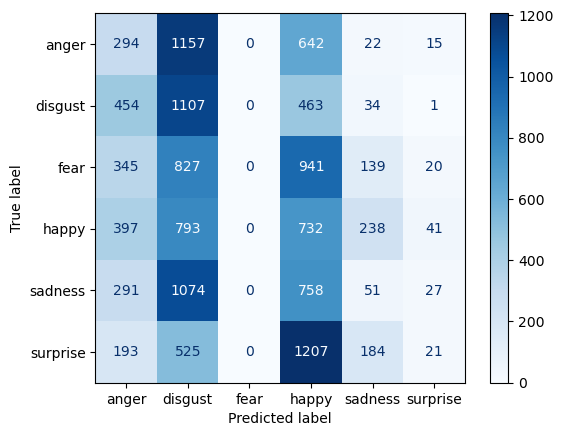

In [7]:
MODEL_NAME = "1_basic_d1.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
# model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


Found 12993 images belonging to 6 classes.
26/26 [==============================] - 43s 2s/step
              precision    recall  f1-score   support

       anger       0.31      0.28      0.29      2130
     disgust       0.26      0.07      0.11      2059
        fear       0.74      0.05      0.10      2272
       happy       0.00      0.00      0.00      2201
     sadness       0.05      0.01      0.01      2201
    surprise       0.19      0.89      0.31      2130

    accuracy                           0.21     12993
   macro avg       0.26      0.22      0.14     12993
weighted avg       0.26      0.21      0.14     12993



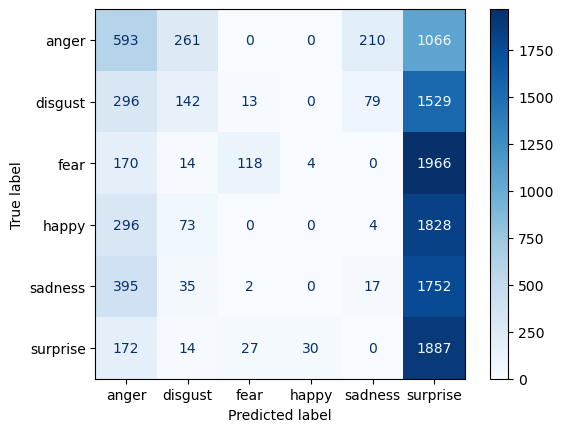

In [8]:
MODEL_NAME = "1_basic_d2.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)




model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 32s 1s/step


C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.32      0.28      0.30      2130
     disgust       0.19      0.25      0.21      2059
        fear       0.22      0.06      0.09      2272
       happy       0.00      0.00      0.00      2201
     sadness       0.23      0.06      0.09      2201
    surprise       0.22      0.75      0.34      2130

    accuracy                           0.23     12993
   macro avg       0.20      0.23      0.17     12993
weighted avg       0.20      0.23      0.17     12993



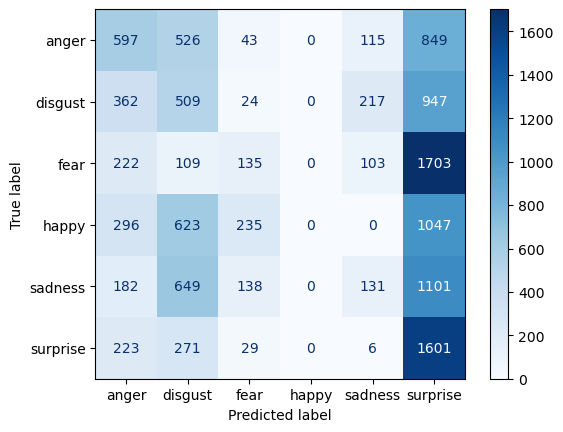

In [9]:
MODEL_NAME = "1_basic_d3.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Model trained with intensity normalized images
Tested with intensity normalized JAFFE images

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 23s 872ms/step


C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.18      0.09      0.12      2130
     disgust       0.21      0.29      0.24      2059
        fear       0.28      0.09      0.14      2272
       happy       0.00      0.00      0.00      2201
     sadness       0.13      0.02      0.03      2201
    surprise       0.16      0.62      0.26      2130

    accuracy                           0.18     12993
   macro avg       0.16      0.18      0.13     12993
weighted avg       0.16      0.18      0.13     12993



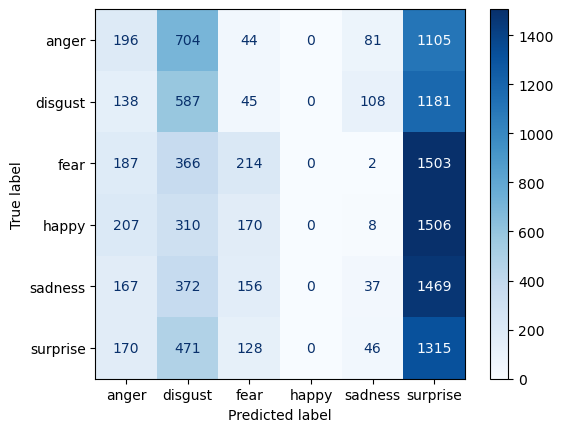

In [10]:
MODEL_NAME =  "1_IN_d1.h5"
test_dir = inten_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 22s 856ms/step


C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.30      0.03      0.05      2130
     disgust       0.17      0.14      0.15      2059
        fear       0.00      0.00      0.00      2272
       happy       0.00      0.00      0.00      2201
     sadness       0.05      0.00      0.00      2201
    surprise       0.17      0.86      0.28      2130

    accuracy                           0.17     12993
   macro avg       0.11      0.17      0.08     12993
weighted avg       0.11      0.17      0.08     12993



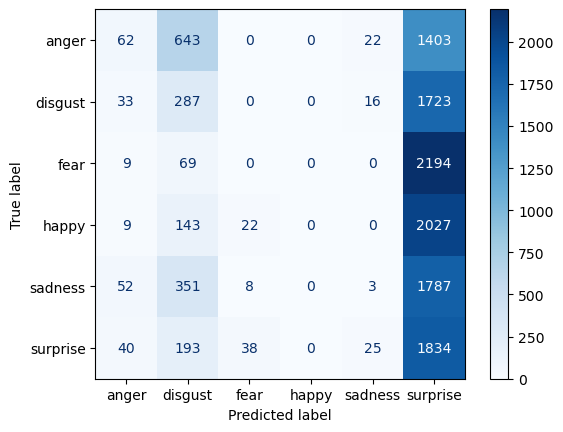

In [11]:
MODEL_NAME = "1_IN_d2.h5"
test_dir = inten_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 21s 798ms/step


C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.28      0.21      0.24      2130
     disgust       0.14      0.14      0.14      2059
        fear       0.00      0.00      0.00      2272
       happy       0.25      0.03      0.05      2201
     sadness       0.15      0.23      0.18      2201
    surprise       0.13      0.35      0.20      2130

    accuracy                           0.16     12993
   macro avg       0.16      0.16      0.13     12993
weighted avg       0.16      0.16      0.13     12993



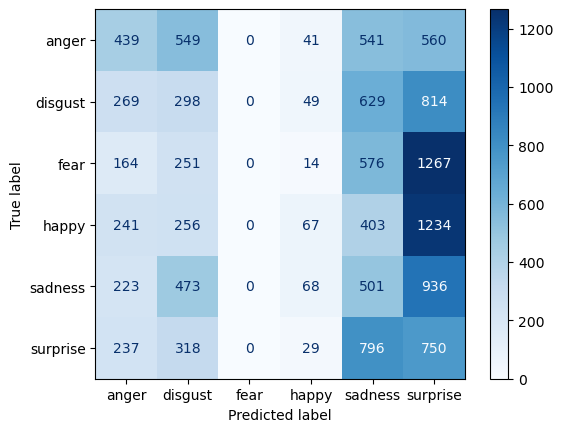

In [12]:
MODEL_NAME =  "1_IN_d3.h5"
test_dir = inten_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Model trained with cropped images
Tested with cropped JAFFE images

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 13s 497ms/step
              precision    recall  f1-score   support

       anger       0.24      0.09      0.13      2130
     disgust       0.17      0.16      0.16      2059
        fear       0.26      0.04      0.07      2272
       happy       0.68      0.61      0.64      2201
     sadness       0.49      0.01      0.03      2201
    surprise       0.24      0.89      0.38      2130

    accuracy                           0.30     12993
   macro avg       0.35      0.30      0.23     12993
weighted avg       0.35      0.30      0.23     12993



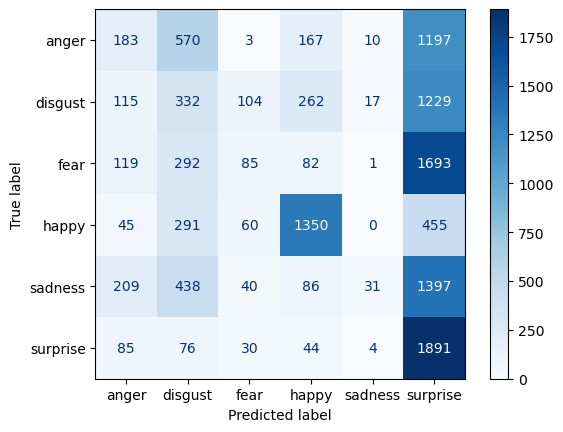

In [13]:
MODEL_NAME = "1_crop_d1.h5"
test_dir = crop_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 12s 451ms/step
              precision    recall  f1-score   support

       anger       0.50      0.00      0.00      2130
     disgust       0.04      0.00      0.00      2059
        fear       0.20      0.00      0.01      2272
       happy       0.48      0.68      0.57      2201
     sadness       0.00      0.00      0.00      2201
    surprise       0.21      0.95      0.34      2130

    accuracy                           0.27     12993
   macro avg       0.24      0.27      0.15     12993
weighted avg       0.24      0.27      0.15     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


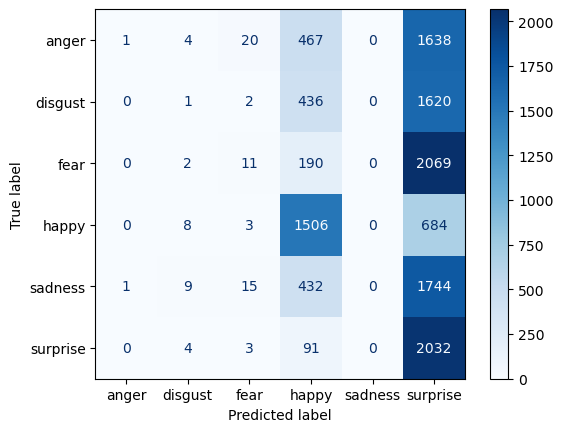

In [14]:
MODEL_NAME = "1_crop_d2.h5"
test_dir = crop_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 12s 461ms/step
              precision    recall  f1-score   support

       anger       0.17      0.00      0.00      2130
     disgust       0.02      0.00      0.00      2059
        fear       0.08      0.00      0.00      2272
       happy       0.42      0.52      0.46      2201
     sadness       0.19      0.01      0.02      2201
    surprise       0.21      0.97      0.34      2130

    accuracy                           0.25     12993
   macro avg       0.18      0.25      0.14     12993
weighted avg       0.18      0.25      0.14     12993



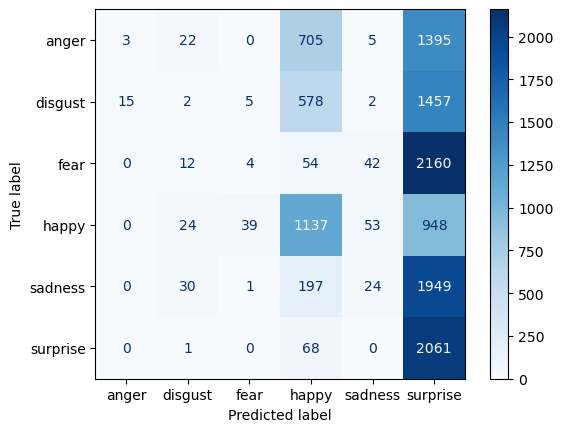

In [15]:
MODEL_NAME = "1_crop_d3.h5"
test_dir = crop_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Model trained with intensity normalization and corpping
Tested with intensity normalized and corpped JAFFE images

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 8s 312ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      2130
     disgust       0.14      0.16      0.15      2059
        fear       0.00      0.00      0.00      2272
       happy       0.39      0.64      0.49      2201
     sadness       0.45      0.01      0.01      2201
    surprise       0.23      0.76      0.36      2130

    accuracy                           0.26     12993
   macro avg       0.20      0.26      0.17     12993
weighted avg       0.20      0.26      0.17     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


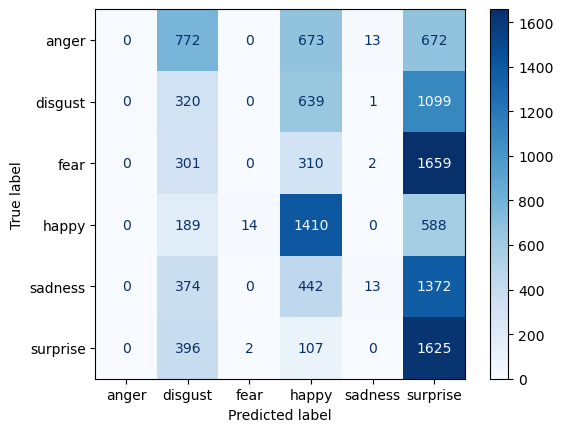

In [16]:
MODEL_NAME = "1_CR_IN_d1.h5"
test_dir = inten_crop_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 7s 256ms/step
              precision    recall  f1-score   support

       anger       1.00      0.01      0.02      2130
     disgust       0.12      0.14      0.13      2059
        fear       1.00      0.00      0.00      2272
       happy       0.48      0.60      0.53      2201
     sadness       0.00      0.00      0.00      2201
    surprise       0.21      0.75      0.32      2130

    accuracy                           0.25     12993
   macro avg       0.47      0.25      0.17     12993
weighted avg       0.47      0.25      0.17     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


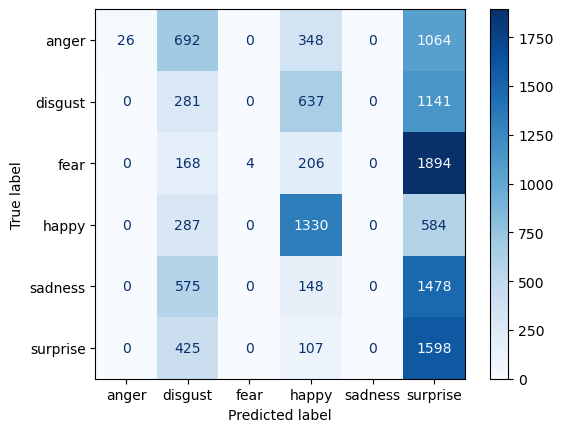

In [17]:
MODEL_NAME = "1_CR_IN_d2.h5"
test_dir = inten_crop_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 7s 267ms/step
              precision    recall  f1-score   support

       anger       1.00      0.00      0.01      2130
     disgust       0.11      0.18      0.14      2059
        fear       1.00      0.00      0.00      2272
       happy       0.47      0.58      0.52      2201
     sadness       0.00      0.00      0.00      2201
    surprise       0.23      0.73      0.34      2130

    accuracy                           0.25     12993
   macro avg       0.47      0.25      0.17     12993
weighted avg       0.47      0.25      0.17     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


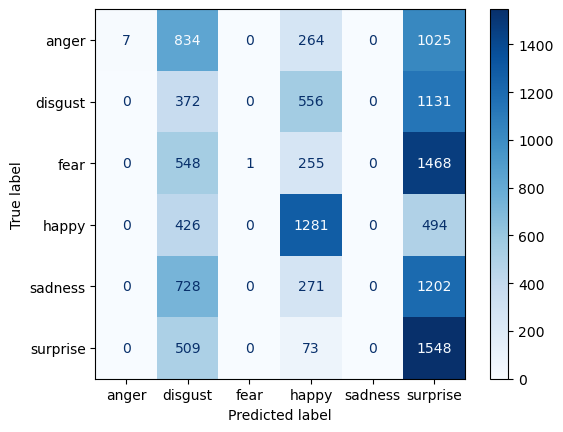

In [18]:
MODEL_NAME = "1_CR_IN_d3.h5"
test_dir = inten_crop_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# TEST with Augmented-only JAFFE datasets

In [4]:

project_folder_name = "C:\\Users\\hsad6\\Desktop\\comp473_conda\\myTest"
aug_jaffe_test_dir = "C:\\Users\\hsad6\\Desktop\\comp473_conda\\JAFFE"


In [5]:
NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"


### Model with no pre-processed images

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 26s 999ms/step
              precision    recall  f1-score   support

       anger       0.15      0.14      0.14      2130
     disgust       0.20      0.54      0.29      2059
        fear       0.00      0.00      0.00      2272
       happy       0.15      0.33      0.21      2201
     sadness       0.08      0.02      0.04      2201
    surprise       0.17      0.01      0.02      2130

    accuracy                           0.17     12993
   macro avg       0.12      0.17      0.12     12993
weighted avg       0.12      0.17      0.11     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


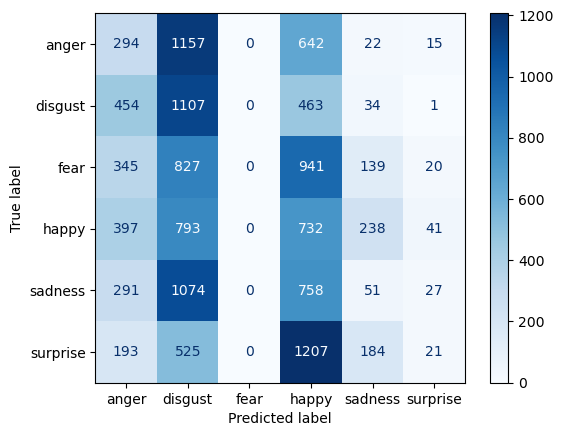

In [6]:
MODEL_NAME = "1_basic_d1.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


Found 12993 images belonging to 6 classes.
26/26 [==============================] - 27s 1s/step
              precision    recall  f1-score   support

       anger       0.31      0.28      0.29      2130
     disgust       0.26      0.07      0.11      2059
        fear       0.74      0.05      0.10      2272
       happy       0.00      0.00      0.00      2201
     sadness       0.05      0.01      0.01      2201
    surprise       0.19      0.89      0.31      2130

    accuracy                           0.21     12993
   macro avg       0.26      0.22      0.14     12993
weighted avg       0.26      0.21      0.14     12993



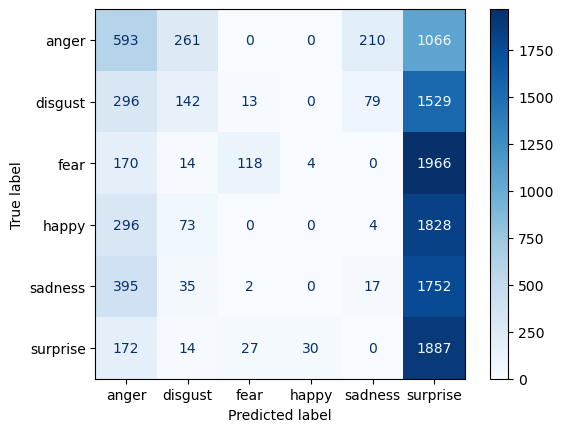

In [7]:
MODEL_NAME = "1_basic_d2.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)





model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)


# model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


Found 12993 images belonging to 6 classes.
26/26 [==============================] - 28s 1s/step
              precision    recall  f1-score   support

       anger       0.32      0.28      0.30      2130
     disgust       0.19      0.25      0.21      2059
        fear       0.22      0.06      0.09      2272
       happy       0.00      0.00      0.00      2201
     sadness       0.23      0.06      0.09      2201
    surprise       0.22      0.75      0.34      2130

    accuracy                           0.23     12993
   macro avg       0.20      0.23      0.17     12993
weighted avg       0.20      0.23      0.17     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


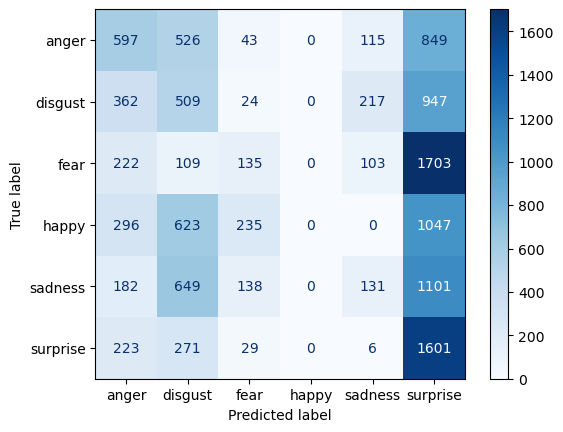

In [8]:
MODEL_NAME = "1_basic_d3.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Model with intensity normalized images

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 27s 1s/step
              precision    recall  f1-score   support

       anger       0.21      0.47      0.29      2130
     disgust       0.17      0.36      0.23      2059
        fear       0.10      0.00      0.01      2272
       happy       0.00      0.00      0.00      2201
     sadness       0.28      0.03      0.06      2201
    surprise       0.12      0.19      0.15      2130

    accuracy                           0.17     12993
   macro avg       0.15      0.18      0.12     12993
weighted avg       0.15      0.17      0.12     12993



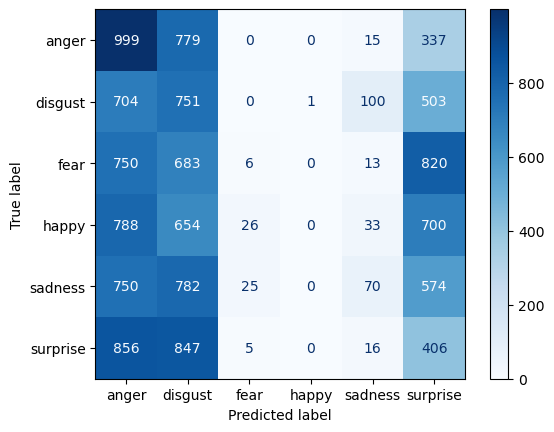

In [9]:
MODEL_NAME =  "1_IN_d1.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 25s 971ms/step
              precision    recall  f1-score   support

       anger       0.41      0.12      0.18      2130
     disgust       0.24      0.43      0.31      2059
        fear       0.00      0.00      0.00      2272
       happy       0.00      0.00      0.00      2201
     sadness       1.00      0.01      0.03      2201
    surprise       0.21      0.84      0.33      2130

    accuracy                           0.23     12993
   macro avg       0.31      0.23      0.14     12993
weighted avg       0.31      0.23      0.14     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


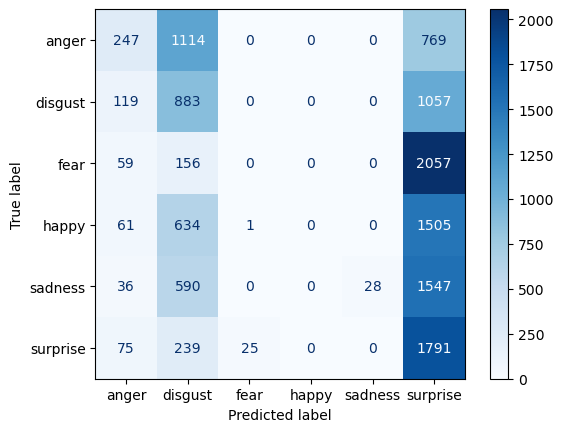

In [10]:
MODEL_NAME = "1_IN_d2.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 26s 984ms/step
              precision    recall  f1-score   support

       anger       0.18      0.42      0.25      2130
     disgust       0.18      0.32      0.23      2059
        fear       0.00      0.00      0.00      2272
       happy       0.50      0.00      0.01      2201
     sadness       0.27      0.11      0.16      2201
    surprise       0.20      0.31      0.24      2130

    accuracy                           0.19     12993
   macro avg       0.22      0.20      0.15     12993
weighted avg       0.22      0.19      0.15     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


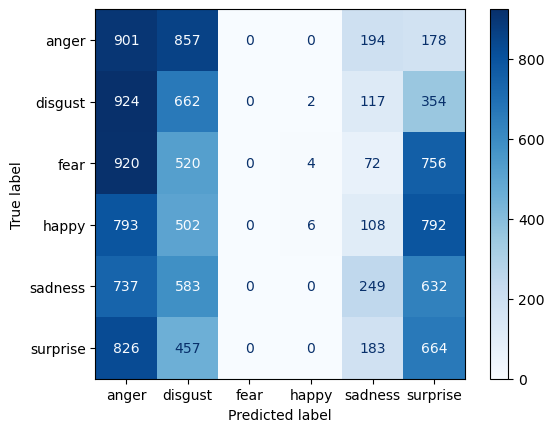

In [11]:
MODEL_NAME =  "1_IN_d3.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Model with cropped images

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 25s 969ms/step
              precision    recall  f1-score   support

       anger       0.20      0.00      0.00      2130
     disgust       0.53      0.15      0.24      2059
        fear       0.00      0.00      0.00      2272
       happy       0.33      0.10      0.15      2201
     sadness       0.19      0.09      0.12      2201
    surprise       0.17      0.87      0.29      2130

    accuracy                           0.20     12993
   macro avg       0.24      0.20      0.13     12993
weighted avg       0.23      0.20      0.13     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


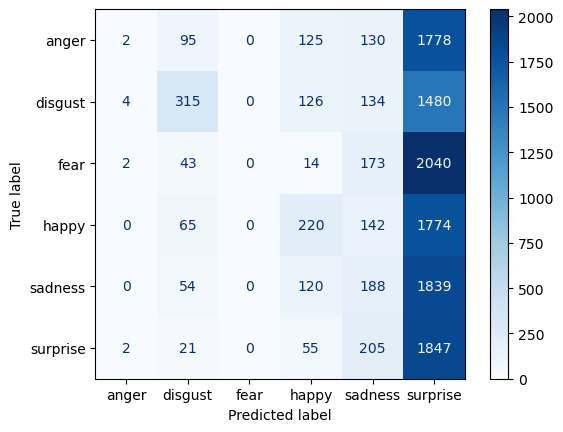

In [12]:
MODEL_NAME = "1_crop_d1.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 26s 980ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      2130
     disgust       0.00      0.00      0.00      2059
        fear       0.37      0.08      0.13      2272
       happy       0.34      0.19      0.24      2201
     sadness       0.19      0.10      0.13      2201
    surprise       0.18      0.88      0.30      2130

    accuracy                           0.21     12993
   macro avg       0.18      0.21      0.13     12993
weighted avg       0.18      0.21      0.14     12993



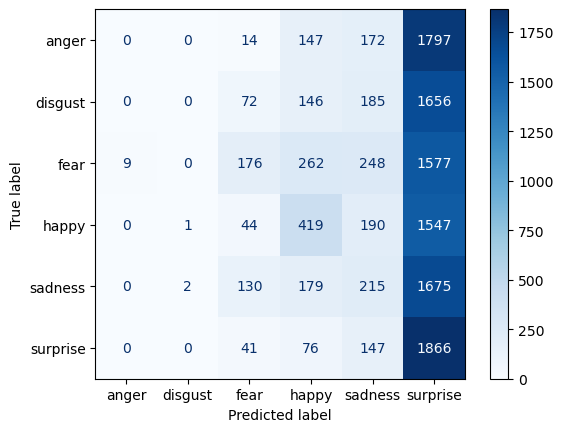

In [13]:
MODEL_NAME = "1_crop_d2.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 26s 989ms/step
              precision    recall  f1-score   support

       anger       0.10      0.03      0.05      2130
     disgust       0.00      0.00      0.00      2059
        fear       0.00      0.00      0.00      2272
       happy       0.24      0.44      0.31      2201
     sadness       0.17      0.03      0.05      2201
    surprise       0.17      0.63      0.27      2130

    accuracy                           0.19     12993
   macro avg       0.12      0.19      0.11     12993
weighted avg       0.12      0.19      0.11     12993



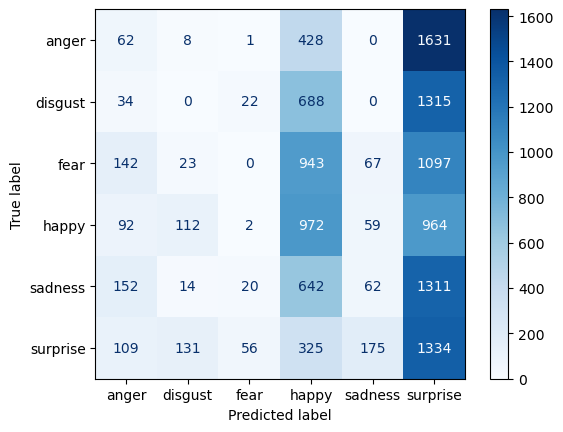

In [14]:
MODEL_NAME = "1_crop_d3.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Model with cropped and intensity normalization

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 26s 1000ms/step
              precision    recall  f1-score   support

       anger       0.07      0.01      0.01      2130
     disgust       0.45      0.03      0.06      2059
        fear       0.71      0.01      0.01      2272
       happy       0.37      0.24      0.29      2201
     sadness       0.27      0.11      0.16      2201
    surprise       0.19      0.89      0.31      2130

    accuracy                           0.21     12993
   macro avg       0.34      0.22      0.14     12993
weighted avg       0.35      0.21      0.14     12993



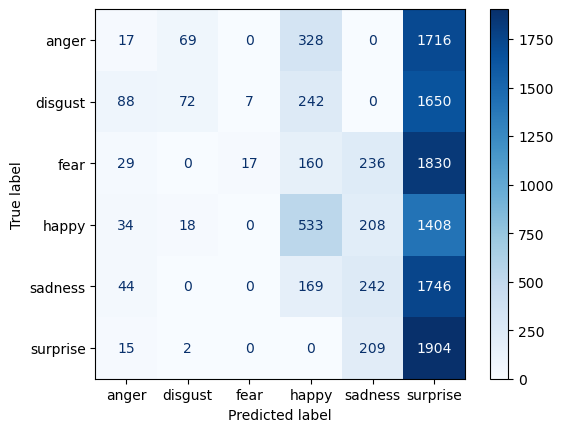

In [15]:
MODEL_NAME = "1_CR_IN_d1.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 26s 984ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      2130
     disgust       0.86      0.05      0.10      2059
        fear       0.00      0.00      0.00      2272
       happy       0.00      0.00      0.00      2201
     sadness       0.00      0.00      0.00      2201
    surprise       0.17      1.00      0.28      2130

    accuracy                           0.17     12993
   macro avg       0.17      0.18      0.06     12993
weighted avg       0.16      0.17      0.06     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


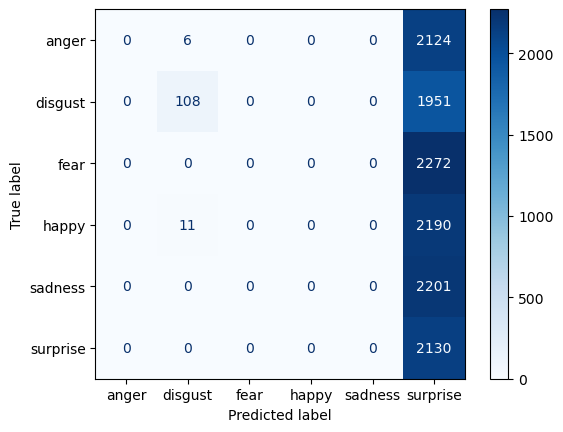

In [16]:
MODEL_NAME = "1_CR_IN_d2.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Found 12993 images belonging to 6 classes.
26/26 [==============================] - 25s 973ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      2130
     disgust       0.76      0.01      0.02      2059
        fear       0.00      0.00      0.00      2272
       happy       0.20      0.01      0.01      2201
     sadness       0.32      0.04      0.07      2201
    surprise       0.16      0.97      0.28      2130

    accuracy                           0.17     12993
   macro avg       0.24      0.17      0.06     12993
weighted avg       0.24      0.17      0.06     12993



C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hsad6\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


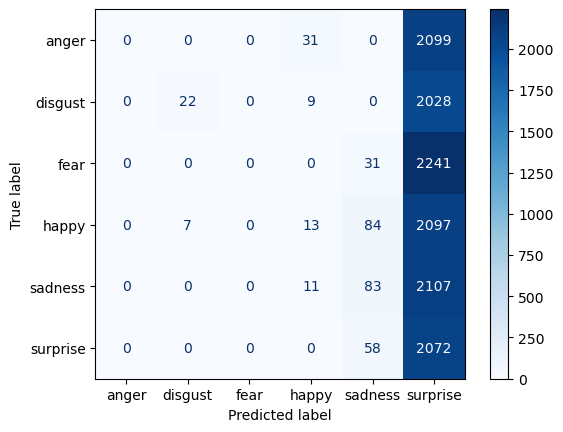

In [17]:
MODEL_NAME = "1_CR_IN_d3.h5"
test_dir = aug_jaffe_test_dir
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)
model = tf.keras.models.load_model(project_folder_name+"\\"+MODEL_NAME)
# model.load_weights(MODEL_NAME)
y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()